In [31]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import string
import json
import numpy as np
import pandas as pd
import re

In [32]:
# Load stemmer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
 
ps = PorterStemmer()

In [33]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [34]:
# ## All datasets
# file = 'data_sets.json'
# directory = '/home/urwa/Documents/Coleridge/ProjectFiles/train_test/train_test/'
# text = load_doc(directory+file)
# loaded_json = json.loads(text)

In [35]:
## Only labelled datasets

file = 'data_sets.json'
directory = '/home/urwa/Documents/Coleridge/ProjectFiles/train_test/train_test/'
text = load_doc(directory+file)

loaded_json_all = json.loads(text)
loaded_json = loaded_json_all

In [ ]:
## uncomment and run when using only the labelled datsets
# file = 'data_set_citations.json'
# directory = '/home/urwa/Documents/Coleridge/ProjectFiles/train_test/train_test/'
# citTemp = pd.read_json(directory+file)
# labelledDatasets = set(citTemp.data_set_id)

# loaded_json=[]
# for lj in loaded_json_all:
#     if lj['data_set_id'] in labelledDatasets:
#         loaded_json.append(lj)

In [37]:
## Abbreviation Disambiguation Module

## load abbreviations
file = 'abbreviations.json'
abbtext = load_doc(file)
abbreviations = json.loads(abbtext)

def findAbbreviation(sentence):
    regex = r"\b[A-Z][A-Z]+\b"
    abbreviations = re.findall(regex, sentence)
    return abbreviations

def expandAbbreviation(sentence, abbdict):
    abbs = findAbbreviation(sentence)
    for a in abbs:
        if a in abbdict:
            sentence = sentence.replace(a,abbdict[a][0])
    return sentence

In [38]:
def specialMapping(word):
    if word == 'studi':
        return 'survey'
    else:
        return word

In [39]:
def treatDates(tokens):
    rawDates = []
    for token in tokens:
        if len(token) == 6: #200108
            if re.match(r'([1-2][0,9][0-9]{4})', token):
                start = int(token[0:4])
                end = int(token[:2]+token[4:6])
                if (end>start):
                    years = list( range(start,end+1) )
                    years = [str(y) for y in years]
                    rawDates.append(token)
                    tokens += years
        if len(token) == 8: #20012008
            if re.match(r'([0-2][0,9][0-9]{2}[0-2][0,9][0-9]{2})', token):
                start = int(token[0:4])
                end = int(token[4:8])
                if (end>start):
                    years = list( range(start,end+1) )
                    years = [str(y) for y in years]
                    rawDates.append(token)
                    tokens += years
    tokens = [t for t in tokens if t not in rawDates]
    return tokens

In [9]:
txt = " ".join([loaded_json[1]['description'], loaded_json[1]['subjects'].replace(',',' '), ' '.join(loaded_json[1]['mention_list'])])

In [48]:
# turn a doc into clean tokens
def clean_doc(doc):
    # abbreviation disambiguation
    doc = expandAbbreviation(doc, abbreviations)
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # stemming
    tokens = [ps.stem(word) for word in tokens]
    #specialMapping
    tokens = [specialMapping(word) for word in tokens]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [49]:
# load doc and add to vocab
def add_doc_to_vocab(dataset, vocab):
    # load doc
    #doc = " ".join([dataset['description'], dataset['subjects'].replace(',',' '), ' '.join(dataset['mention_list'])])
    #doc = " ".join([dataset['description'], dataset['subjects'].replace(',',' ')])
    doc = dataset['title']
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

In [50]:
# save list to file
def save_list(lines, filename):
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [51]:
# define vocab
vocab = Counter()
for dataset in loaded_json:    
    add_doc_to_vocab(dataset, vocab)
tokens = [k for k,c in vocab.items()]
save_list(tokens, 'dataset_vocab_production.txt')

# Load and process Dataset

In [52]:
vocab = load_doc('dataset_vocab_production.txt').split()

In [53]:
dataSetIds = [ dataset['data_set_id'] for dataset in loaded_json ]

In [54]:
# load doc, clean and return line of tokens
def data_to_line(dataset, vocab):
    # load the doc
    #doc = " ".join([dataset['description'], dataset['subjects'].replace(',',' '), ' '.join(dataset['mention_list'])])
    doc = dataset['title']
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [55]:
dataLines = []
for data in loaded_json:
    dataLines.append(data_to_line(data, vocab))
save_list(dataLines, 'datasets_lines_production.txt')

# N gram Vector of each Dataset

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

# each field as a sentence
docs = load_doc('datasets_lines.txt').split('\n')

# create the tokenizer
vectorizer = TfidfVectorizer(ngram_range=(2, 4))

# fit the tokenizer on the documents
tfidVec = vectorizer.fit(docs)

# encode training data set
dataset_bow = tfidVec.transform(docs)
print(dataset_bow.shape)

(1028, 151610)


## Load and Process Documents

In [134]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
	# load the doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# filter by vocab
	tokens = [w for w in tokens if w in vocab]
	return ' '.join(tokens)

In [135]:
# load all docs in a directory
def process_docs_bow(directory,files, vocab):
    lines = list()
    for f in files:
        path = directory + f
        line = doc_to_line(path, vocab)
        lines.append(line)
    return lines

In [136]:
#Load the text files which were labelled
txtFiles = load_doc('labelledTextFiles.txt').split('\n')
txtFiles[:5]

['2108.txt', '2272.txt', '1609.txt', '589.txt', '206.txt']

In [137]:
directory = '/home/urwa/Documents/Coleridge/ProjectFiles/train_test/train_test/files/text/'

In [138]:
# prepare documents
processed_lines = process_docs_bow(directory,txtFiles, vocab)
save_list(processed_lines, 'sample_datasets_lines.txt')

## N gram Vector of Documents

In [139]:
# each field as a sentence
docs = load_doc('sample_datasets_lines.txt').split('\n')

# encode training data set
docs_bow = tfidVec.transform(docs)
print(docs_bow.shape)

(2500, 151610)


# Cosine Similarity

In [140]:
from sklearn.metrics.pairwise import cosine_similarity

Cos_Sim = cosine_similarity(docs_bow, dataset_bow, dense_output=True)

In [141]:
Cos_Sim.shape

(2500, 1028)

## Label Data on Maximum Cosine Similarity

In [143]:
DataLabel = []
Score = []
for i in range(Cos_Sim.shape[0]):
    DataLabel.append( dataSetIds[np.argmax(Cos_Sim[i])] )
    Score.append( max(Cos_Sim[i]) )

In [144]:
DF = pd.DataFrame({'file': txtFiles, 'datasetId': DataLabel, 'score':Score })
DF.head(10)

,file,datasetId,score
0,2108.txt,483,0.635886
1,2272.txt,594,0.164430
2,1609.txt,518,0.458769
3,589.txt,438,0.206369
4,206.txt,382,0.899226
5,897.txt,382,0.771571
6,2613.txt,1179,0.095458
7,1678.txt,523,0.280588
8,2796.txt,1165,0.188339
9,1791.txt,382,0.469554


# Prepare true labels

In [147]:
file = 'publications.json'
directory = '/home/urwa/Documents/Coleridge/ProjectFiles/train_test/train_test/'
pub_json = pd.read_json(directory+file)

In [148]:
pub_json.head()

,pdf_file_name,pub_date,publication_id,text_file_name,title,unique_identifier
0,105.pdf,1969-01-01,105,105.txt,Cheap Talk? Financial Sanctions and Non-Financ...,bbk-4
1,109.pdf,1969-01-01,109,109.txt,Banks' Trading after the Lehman Crisis - The R...,bbk-8
2,110.pdf,1969-01-01,110,110.txt,A Comprehensive View on Risk Reporting: Eviden...,bbk-9
3,111.pdf,1969-01-01,111,111.txt,The Financial Market Effects of the ECB's Asse...,bbk-10
4,115.pdf,1969-01-01,115,115.txt,Interbank Intermediation,bbk-14


In [149]:
pub_json = pub_json[['text_file_name','publication_id']]
pub_json = pub_json[pub_json.text_file_name.apply(lambda x: x in txtFiles)]
pub_json.head()

,text_file_name,publication_id
0,105.txt,105
1,109.txt,109
2,110.txt,110
3,111.txt,111
4,115.txt,115


In [150]:
file = 'data_set_citations.json'
directory = '/home/urwa/Documents/Coleridge/ProjectFiles/train_test/train_test/'
cit = pd.read_json(directory+file)

In [151]:
cit = cit[['data_set_id', 'publication_id']]
cit.head()

,data_set_id,publication_id
0,311,105
1,312,105
2,321,109
3,307,109
4,322,109


In [152]:
pub_json = pub_json.merge(cit, left_on=['publication_id'], right_on=['publication_id'], how='left')
pub_json.head()

,text_file_name,publication_id,data_set_id
0,105.txt,105,311
1,105.txt,105,312
2,109.txt,109,321
3,109.txt,109,307
4,109.txt,109,322


In [153]:
len(pub_json)

5499

In [154]:
pub_json = pub_json[['text_file_name','data_set_id']]
pub_json.columns =  ['file','data_set_id']

## Validate

In [155]:
validationDF = DF.merge(pub_json,left_on=['file'], right_on=['file'], how = 'left')
validationDF.head()

,file,datasetId,score,data_set_id
0,2108.txt,483,0.635886,542
1,2272.txt,594,0.164430,594
2,1609.txt,518,0.458769,518
3,589.txt,438,0.206369,438
4,206.txt,382,0.899226,422


In [156]:
len(validationDF)

5499

In [157]:
sum(validationDF.datasetId == validationDF.data_set_id)

1656

## Find a threshhold

In [158]:
a = validationDF.score[validationDF.datasetId == validationDF.data_set_id]
np.mean(a)

0.4728028814013284

In [159]:
b = validationDF.score[validationDF.datasetId != validationDF.data_set_id]
np.mean(b)

0.4209399926408107

In [160]:
import scipy as sp
from scipy import stats

sp.stats.ks_2samp(a,b)

Ks_2sampResult(statistic=0.10622362511172201, pvalue=7.522173896692725e-12)

#### They have differnet distributions. Lets find the optimal threshhold value

In [161]:
pd.DataFrame(Cos_Sim).to_csv('bi_tri_gram_array.csv')

In [162]:
def getTop(arr,n,i):
    pdf = pd.DataFrame({"score": arr, 'ind':range(0,len(arr))})
    pdf = pdf.sort_values(by='score',ascending=False)
    pdf['datasetId'] = pdf.ind.apply(lambda x: dataSetIds[x])
    pdf['file'] = txtFiles[i]
    pdf = pdf[pdf.score > 0]
    pdf['zcore'] = (pdf.score - np.mean(pdf.score)) / np.std(pdf.score)
    return(pdf[:n])

In [163]:
results = getTop(Cos_Sim[0],50,0)
for i in range(1,Cos_Sim.shape[0]):
    results = results.append(getTop(Cos_Sim[i],50,i))

results.head(7)

,score,ind,datasetId,file,zcore
235,0.635886,235,483,2108.txt,6.387247
233,0.634713,233,481,2108.txt,6.374924
236,0.634334,236,484,2108.txt,6.370941
234,0.633653,234,482,2108.txt,6.363787
292,0.628047,292,542,2108.txt,6.304890
156,0.612210,156,400,2108.txt,6.138497
91,0.607889,91,260,2108.txt,6.093101


In [164]:
valResults =  results.merge(pub_json,left_on=['file','datasetId'], right_on=['file','data_set_id'], how = 'left')

In [165]:
len(valResults)
#-len(results)

124964

In [167]:
valResults['Hit'] = ~valResults.data_set_id.isna()

In [168]:
sum(valResults.Hit)

5211

In [170]:
import seaborn as sns

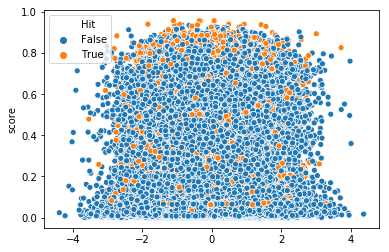

In [171]:
sns.scatterplot(x=np.random.randn(len(valResults)), y="score", hue="Hit",
                      data=valResults)

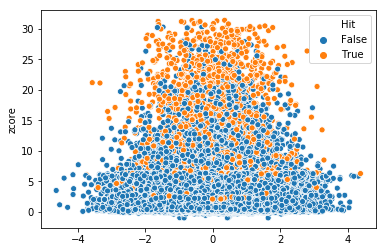

In [172]:
sns.scatterplot(x=np.random.randn(len(valResults)), y="zcore", hue="Hit",
                      data=valResults)

In [173]:
sum(~valResults.data_set_id.isna())/ len(valResults)

0.0417000096027656

In [174]:
for t in np.linspace(1,20,80):
    temp = valResults[valResults.zcore > t]
    precision = sum(~temp['data_set_id'].isna())/len(temp)
    recall = sum(~temp['data_set_id'].isna())/5499
    print(str(t)+" : "+ str(2*(precision * recall)/(precision + recall)) +" p: "+str(precision)+" r: "+str(recall)  )

1.0 : 0.1086425448483387 p: 0.05764480740559425 r: 0.9421713038734315
1.240506329113924 : 0.11710885393665568 p: 0.06244264116311646 r: 0.9403527914166212
1.481012658227848 : 0.12539985647737087 p: 0.06719413957610991 r: 0.9374431714857246
1.7215189873417722 : 0.13540008158216774 p: 0.07298079378138386 r: 0.9356246590289143
1.9620253164556962 : 0.1444510352230037 p: 0.07830707274870993 r: 0.9299872704128024
2.2025316455696204 : 0.15460686465433301 p: 0.08436135416493716 r: 0.9239861793053282
2.4430379746835444 : 0.16338909771403679 p: 0.08964735873105792 r: 0.9208947081287506
2.6835443037974684 : 0.17326357816479657 p: 0.09568704974434032 r: 0.9154391707583197
2.9240506329113924 : 0.18290294833549894 p: 0.10168491310894957 r: 0.9087106746681215
3.1645569620253164 : 0.19219440353460973 p: 0.10755883309836244 r: 0.9018003273322422
3.4050632911392404 : 0.1992845160377549 p: 0.1121015052981036 r: 0.8965266412074923
3.6455696202531644 : 0.20545623993899856 p: 0.11627070697384509 r: 0.881978